In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.cm as cm

#per la rimozione degli outliers
from scipy import stats

#per la vecchia regressione
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

#dal notebook del professore
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler


from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)

#knn
from sklearn.neighbors import KNeighborsClassifier

#grid search
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scikitplot.metrics import plot_precision_recall

#naive bayes
from sklearn.naive_bayes import GaussianNB, CategoricalNB

#decision tree
from sklearn.tree import DecisionTreeClassifier, plot_tree

#randomized search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

## Preproessing

In [3]:
df=pd.read_csv('train.csv', skipinitialspace=True)

In [4]:
df=df.drop(['features_duration_ms'], axis=1)

In [5]:
df['duration_ms'] = df['duration_ms'].apply(lambda x: x/1000)

In [6]:
genres = sorted(df['genre'].unique())
genres_mapping = dict(zip(genres, range(0, len(genres) + 1)))
df['genres_val'] = df['genre'].map(genres_mapping).astype(int)

expl = sorted(df['explicit'].unique())
expl_mapping = dict(zip(expl, range(0, len(expl) + 1)))

df['explicit_val'] = df['explicit'].map(expl_mapping).astype(int)

In [7]:
dft=df.drop(['name', 'explicit', 'artists','album_name', 'genre', 'mode', 'popularity_confidence'], axis=1)
dfp=df.drop(['name', 'explicit', 'artists','album_name', 'genre', 'mode', 'time_signature'], axis=1)
dfm=df.drop(['name', 'explicit', 'artists','album_name', 'genre', 'popularity_confidence', 'time_signature'], axis=1)

In [8]:
df

,name,duration_ms,explicit,popularity,artists,album_name,danceability,energy,key,loudness,...,valence,tempo,time_signature,n_beats,n_bars,popularity_confidence,processing,genre,genres_val,explicit_val
0,Untrue,206.826,False,32,Coal Chamber,Chamber Music,0.383,0.9510,0,-3.743,...,0.668,110.584,4.0,385.0,96.0,NaN,3.349057,industrial,11,0
1,High Roller,329.733,False,41,The Crystal Method,Vegas,0.464,0.5790,5,-9.136,...,0.140,171.752,4.0,935.0,235.0,NaN,1.279305,breakbeat,4,0
2,Na Tum Jano Na Hum (ReVibe),136.000,False,40,Ashwin Adwani,Na Tum Jano Na Hum (ReVibe),0.611,0.7780,9,-4.803,...,0.285,90.024,4.0,200.0,49.0,NaN,1.343558,indian,10,0
3,いじわるなハロー,247.040,False,25,Perfume,Cling Cling,0.500,0.9580,0,-1.695,...,0.955,130.059,4.0,526.0,132.0,NaN,3.349057,j-idol,14,0
4,Hit The Ceiling,208.120,False,0,Audio Bullys,Ego War,0.802,0.6840,1,-8.839,...,0.637,130.022,4.0,440.0,110.0,NaN,2.367412,breakbeat,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Ich war es,80.813,False,17,Germaine Franco,Encanto (Deutscher Original Film-Soundtrack),0.217,0.0754,11,-16.629,...,0.201,142.026,5.0,175.0,44.0,0.728,0.748116,disney,6,0
4996,Giahe Vahshi,261.500,False,2,Saeed Dehghan;Pari Eskandari;Beatbynajwa,Oryan,0.467,0.7820,10,-8.136,...,0.203,145.059,4.0,621.0,158.0,NaN,0.757389,iranian,12,0
4997,Taste - Reaper Remix,258.000,False,19,Shiv-R,"Infacted Compilation, Vol. 5",0.524,0.9730,0,-5.214,...,0.840,140.029,4.0,594.0,149.0,NaN,3.349057,industrial,11,0
4998,Romove,404.506,False,19,Skyforger,Senprusija,0.166,0.9750,2,-3.585,...,0.233,75.005,4.0,550.0,138.0,NaN,3.700483,black-metal,1,0


## Divisione dataset

In [9]:
testt=dft[dft['time_signature'].isnull()]
traint=dft[~dft['time_signature'].isnull()]

testp=dfp[dfp['popularity_confidence'].isnull()]
trainp=dfp[~dfp['popularity_confidence'].isnull()]

testm=dfm[dfm['mode'].isnull()]
trainm=dfm[~dfm['mode'].isnull()]

# Time signature

In [10]:
X_iniz=traint[['duration_ms', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'n_beats', 'n_bars', 'processing', 'popularity']]
y_iniz=traint['time_signature']
X_test=testt[['duration_ms', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'n_beats', 'n_bars', 'processing', 'popularity']]
y_test=testt['time_signature']

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_iniz, y_iniz, test_size=0.2, random_state=42)

In [12]:
k_values = list(range(1, 21))

from sklearn.model_selection import cross_val_score

results = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_score = -scores.mean()  # Poiché vogliamo massimizzare il punteggio, invertiamo il segno
    results.append((k, mean_score))
    
best_k = min(results, key=lambda x: x[1])[0]
print(f"Il miglior valore di k è: {best_k}")

Il miglior valore di k è: 7


In [13]:
reg = KNeighborsRegressor(n_neighbors=9)

In [14]:
reg.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=9)

In [15]:
y_pred = reg.predict(X_val)
print('R2: %.3f' % r2_score(y_val, y_pred))
print('MSE: %.3f' % mean_squared_error(y_val, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_val, y_pred))

R2: 0.356
MSE: 0.184
MAE: 0.158


In [16]:
tspred=reg.predict(X_test)

# Popularity confidence

In [17]:
X_iniz=trainp[['duration_ms', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'n_beats', 'n_bars', 'processing', 'popularity']]
y_iniz=trainp['popularity_confidence']
X_test=testp[['duration_ms', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'n_beats', 'n_bars', 'processing', 'popularity']]
y_test=testp['popularity_confidence']

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_iniz, y_iniz, test_size=0.2, random_state=42)

In [19]:
regression_model = Ridge(alpha=0.5)

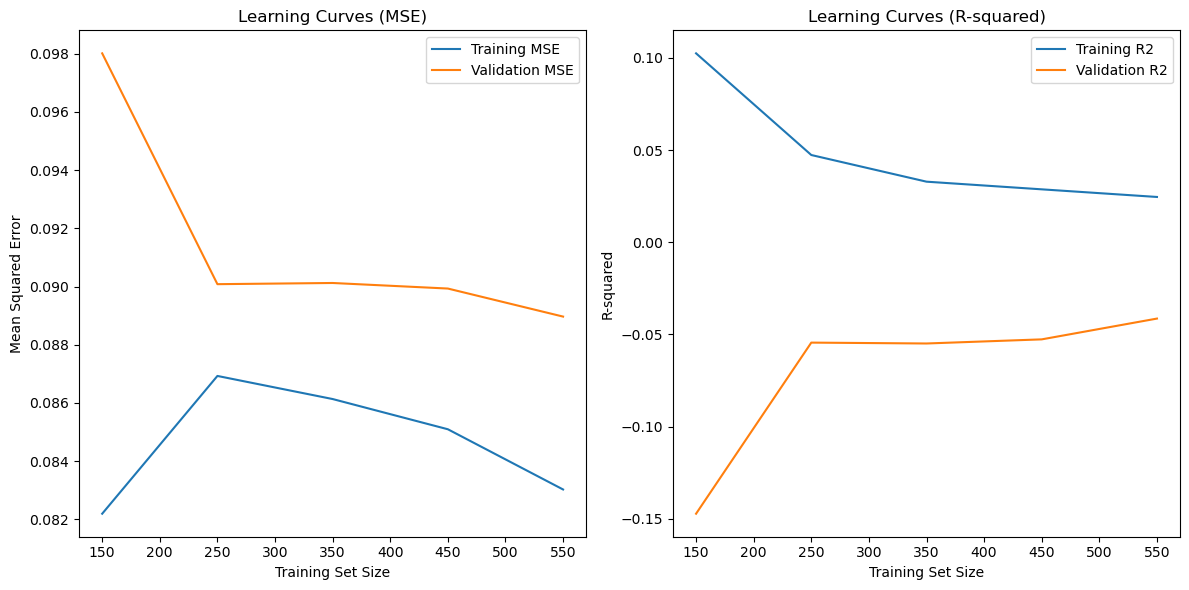

-0.04137490504691166
0.0889676762184651


In [20]:
train_sizes, train_mse, val_mse, train_r2, val_r2 = [], [], [], [], []

for train_size in range(150, len(X_train), 100):  # You can adjust the step size
    X_subset, y_subset = X_train[:train_size], y_train[:train_size]
    
    regression_model.fit(X_subset, y_subset)
    
    # Make predictions on the validation set
    y_val_pred = regression_model.predict(X_val)
    
    # Calculate validation MSE and R-squared
    val_mse_value = mean_squared_error(y_val, y_val_pred)
    val_r2_value = r2_score(y_val, y_val_pred)
    
    train_sizes.append(train_size)
    train_mse.append(mean_squared_error(y_subset, regression_model.predict(X_subset)))
    val_mse.append(val_mse_value)
    train_r2.append(r2_score(y_subset, regression_model.predict(X_subset)))
    val_r2.append(val_r2_value)

# Plot learning curves for MSE and R-squared
plt.figure(figsize=(12, 6))

# Plot MSE
plt.subplot(1, 2, 1)
plt.plot(train_sizes, train_mse, label='Training MSE')
plt.plot(train_sizes, val_mse, label='Validation MSE')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Learning Curves (MSE)')

# Plot R-squared
plt.subplot(1, 2, 2)
plt.plot(train_sizes, train_r2, label='Training R2')
plt.plot(train_sizes, val_r2, label='Validation R2')
plt.xlabel('Training Set Size')
plt.ylabel('R-squared')
plt.legend()
plt.title('Learning Curves (R-squared)')

plt.tight_layout()
plt.show()

print(val_r2_value)
print(val_mse_value)

In [21]:
y_pred = regression_model.predict(X_val)
print('R2: %.3f' % r2_score(y_val, y_pred))
print('MSE: %.3f' % mean_squared_error(y_val, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_val, y_pred))

R2: -0.041
MSE: 0.089
MAE: 0.259


In [22]:
pcpred=regression_model.predict(X_test)

# Mode

In [23]:
X_iniz=trainm[['duration_ms', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'n_beats', 'n_bars', 'processing', 'popularity']]
y_iniz=trainm['mode']
X_test=testm[['duration_ms', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'n_beats', 'n_bars', 'processing', 'popularity']]
y_test=testm['mode']

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X_iniz, y_iniz, test_size=0.2, random_state=42)

In [25]:
attributes = [col for col in dfm.columns if col != 'mode']

In [26]:
%%time
param_list = {
    'max_depth': [None] + list(np.arange(2, 20)),
    'min_samples_split': [2, 5, 10, 20, 30, 50, 100],
    'min_samples_leaf': [1, 5, 10, 20, 30, 50, 100],
    'criterion': ['gini', 'entropy']
}

clf = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1)

random_search = RandomizedSearchCV(
    DecisionTreeClassifier(),
    param_distributions=param_list,
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    refit=True,
    n_iter=200,
    #verbose=2
)

random_search.fit(X_train, y_train)
clf = random_search.best_estimator_

Wall time: 25.8 s


In [27]:
print(random_search.best_params_, random_search.best_score_)

{'min_samples_split': 5, 'min_samples_leaf': 50, 'max_depth': 4, 'criterion': 'entropy'} 0.6917020335159322


In [28]:
y_val_pred = clf.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_val_pred))

Accuracy: 0.7217514124293786


In [29]:
modepred=clf.predict(X_test)

In [30]:
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

         0.0       0.68      0.46      0.55       261
         1.0       0.74      0.87      0.80       447

    accuracy                           0.72       708
   macro avg       0.71      0.67      0.67       708
weighted avg       0.72      0.72      0.71       708



# Sostituzione

In [31]:
df.loc[df['mode'].isnull(), 'mode'] = modepred

In [32]:
df.loc[df['time_signature'].isnull(), 'time_signature'] = tspred

In [33]:
df.loc[df['popularity_confidence'].isnull(), 'popularity_confidence'] = pcpred

## Rimozione outliers

In [34]:
from scipy import stats

# Select only numeric columns for z-score calculation (excluding non-numeric or string columns)
numeric_columns = df[['duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'n_beats', 'n_bars', 'processing']]

z_scores = np.abs(stats.zscore(numeric_columns))
threshold = 3  # Set a threshold for z-score (usually 2 to 3)

# Find outliers using z-score
outliers = (z_scores > threshold).any(axis=1)


df_no_outliers = df[~outliers]

In [35]:
df_no_outliers.to_csv("file_train_senza_outliers_2.csv")


## Prove a caso per un'altra cosa, non serve le guardiate

In [36]:
df2=pd.read_csv('train.csv', skipinitialspace=True)

In [37]:
df2.head()

,name,duration_ms,explicit,popularity,artists,album_name,danceability,energy,key,loudness,...,liveness,valence,tempo,features_duration_ms,time_signature,n_beats,n_bars,popularity_confidence,processing,genre
0,Long Road,241760,False,46,Funki Porcini,Hed Phone Sex,0.690,0.513,5,-12.529,...,0.281,0.6350,142.221,241760,4.0,567.0,141.0,NaN,1.279305,j-dance
1,"Daniâl My Son, Where Did You Vanish?",444000,False,0,Siavash Amini,A Trail of Laughters,0.069,0.196,1,-24.801,...,0.360,0.0336,75.596,444000,4.0,617.0,155.0,NaN,2.367412,iranian
2,Ondskapens Galakse,333506,False,3,Kvelertak,Nattesferd,0.363,0.854,2,-7.445,...,0.262,0.4890,116.628,333507,4.0,652.0,162.0,NaN,3.700483,black-metal
3,Can't Look Away,269800,False,23,The Wood Brothers,One Drop of Truth,0.523,0.585,5,-5.607,...,0.117,0.3850,140.880,269800,4.0,619.0,155.0,0.469,1.279305,bluegrass
4,Thunderground,307651,False,25,The Darkraver;DJ Vince,Happy Hardcore Top 100,0.643,0.687,7,-11.340,...,0.299,0.6370,143.956,307652,4.0,733.0,183.0,NaN,4.067086,happy


In [51]:
df2['tempo'].describe()

count    15000.000000
mean       123.116544
std         31.930958
min          0.000000
25%         99.939000
50%        124.188000
75%        141.986500
max        220.525000
Name: tempo, dtype: float64

In [52]:
df2["energy"].describe()

count    15000.000000
mean         0.656231
std          0.264371
min          0.000000
25%          0.480000
50%          0.709000
75%          0.884000
max          1.000000
Name: energy, dtype: float64

In [54]:
df2[df2['tempo']>220]

,name,duration_ms,explicit,popularity,artists,album_name,danceability,energy,key,loudness,...,liveness,valence,tempo,features_duration_ms,time_signature,n_beats,n_bars,popularity_confidence,processing,genre
9785,Hip Hip Pooh Rah,88641,False,14,Billboard Baby Lullabies,Lullaby Renditions of Winnie the Pooh,0.244,0.323,0,-18.836,...,0.143,0.359,220.525,88641,4.0,312.0,78.0,0.935,3.349057,disney
13630,Heffalumps and Woozles,108777,False,17,Billboard Baby Lullabies,Lullaby Renditions of Winnie the Pooh,0.225,0.257,0,-16.993,...,0.165,0.295,220.084,108777,4.0,381.0,95.0,NaN,3.349057,disney


In [53]:
df2[(df2['tempo']<99.939000)&(df2["energy"]>0.884000)]

,name,duration_ms,explicit,popularity,artists,album_name,danceability,energy,key,loudness,...,liveness,valence,tempo,features_duration_ms,time_signature,n_beats,n_bars,popularity_confidence,processing,genre
71,ラッキー7,194920,False,26,Flower,Hitomi No Oku No Milkyway,0.674,0.914,7,-3.311,...,0.0402,0.778,93.003,194920,4.0,293.0,73.0,NaN,4.067086,j-idol
168,Diga pra Mim,221973,False,0,Zezo,25 Sucessos de Zezo (O Principe dos Teclados),0.694,0.904,4,-4.650,...,0.0445,0.670,90.003,221973,4.0,332.0,82.0,NaN,0.916010,forro
173,Hardcore To Da Bone,316213,False,18,Masters of Ceremony,The Best Hardcore Classics Ever,0.707,0.961,7,-3.419,...,0.1540,0.161,92.509,316213,4.0,486.0,123.0,NaN,4.067086,happy
191,against,229226,False,16,Sayaka Yamamoto,ゼロ ユニバース,0.486,0.936,2,-2.976,...,0.0942,0.475,94.953,229227,4.0,347.0,88.0,NaN,3.700483,j-idol
218,Geração Coca-Cola,141400,False,48,Legião Urbana,Mais Do Mesmo,0.574,0.890,6,-5.789,...,0.0741,0.830,97.900,141400,4.0,225.0,56.0,NaN,1.170953,brazil
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14873,Peptalkin' (Original Mix) - Extended Mix,294333,False,5,The Prophet,The Hardcore Archive Part 3 (1997),0.749,0.921,6,-8.182,...,0.1210,0.414,99.075,294333,4.0,484.0,121.0,NaN,1.170953,happy
14907,Triunfo - Live,273426,False,33,Criolo;Emicida,Criolo E Emicida Ao Vivo (Live),0.540,0.945,1,-5.021,...,0.4050,0.551,92.013,273427,4.0,416.0,106.0,NaN,2.367412,afrobeat
14911,Tempo - Tribute Mix by Tenor Fly,268800,False,16,Ed Solo;Deekline,"Welcome To The Jungle, Vol. 2: The Ultimate Ju...",0.645,0.951,10,-3.415,...,0.0798,0.584,87.499,268800,4.0,392.0,98.0,NaN,0.757389,breakbeat
14931,Poly's dollhouse,194000,False,9,arai tasuku,Sin of Children: re,0.213,0.910,7,-5.684,...,0.2230,0.188,84.652,194000,3.0,305.0,101.0,NaN,4.067086,idm


In [55]:
df2[(df2['tempo']>141.986500)&(df2["energy"]<0.480000)]

,name,duration_ms,explicit,popularity,artists,album_name,danceability,energy,key,loudness,...,liveness,valence,tempo,features_duration_ms,time_signature,n_beats,n_bars,popularity_confidence,processing,genre
13,知足,256692,False,51,Mayday,知足 just my pride 最真傑作選,0.406,0.2300,4,-9.007,...,0.1070,0.395,159.914,256693,4.0,667.0,167.0,NaN,0.916010,mandopop
106,Be Kind,247433,False,33,Rival Consoles,Persona,0.507,0.3430,10,-20.092,...,0.1020,0.450,154.096,247434,4.0,620.0,153.0,NaN,0.757389,idm
212,說好不哭,220693,False,63,Jay Chou;Ashin Chen,最偉大的作品,0.513,0.3630,10,-11.219,...,0.0792,0.383,151.828,220693,4.0,542.0,136.0,NaN,0.757389,mandopop
240,Unashamed - Beauty In The Broken Album Version,304853,False,39,Starfield,Beauty In The Broken,0.442,0.4580,5,-7.875,...,0.1870,0.139,153.991,304853,4.0,776.0,195.0,NaN,1.279305,afrobeat
250,FUE,242833,False,59,Manuel Carrasco,FUE,0.744,0.4150,6,-8.417,...,0.1110,0.692,145.988,242833,4.0,585.0,147.0,NaN,1.170953,spanish
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14832,Alpha Meditation,156734,False,60,Brainbox,Alpha Meditation,0.146,0.0138,7,-33.870,...,0.1110,0.102,143.265,156735,4.0,370.0,91.0,0.118,4.067086,sleep
14853,Peer Pressure,110000,False,6,arai tasuku,Fantasmagorie The Ghost Show -Original Soundtr...,0.667,0.1820,6,-16.358,...,0.1040,0.389,170.038,110000,3.0,306.0,101.0,NaN,1.170953,idm
14880,Mi Último Fracaso,265086,False,28,Juanafé;La Flor del Recuerdo,Mi Último Fracaso,0.457,0.3320,0,-10.365,...,0.1020,0.305,164.096,265086,3.0,714.0,238.0,NaN,3.349057,afrobeat
14887,Nocturnal Jam,121414,False,9,"Sarah, the Illstrumentalist",The Next Ten Vol. 1,0.695,0.2610,6,-7.062,...,0.1310,0.423,167.540,121414,4.0,335.0,83.0,0.022,1.170953,study


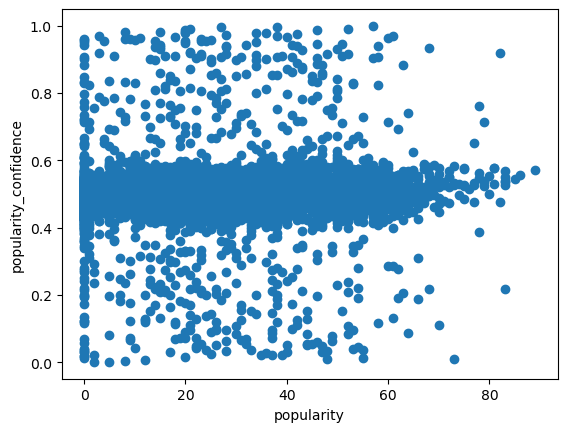

In [45]:
plt.scatter(df_no_outliers['popularity'], df_no_outliers['popularity_confidence'])
plt.xlabel('popularity')
plt.ylabel('popularity_confidence')
plt.show()

In [68]:
sottodf=df2[(df2["tempo"]>160)&(df2["tempo"]<200)]
attr=["tempo", "energy"]
sottodf=sottodf[attr]

In [61]:
sottodf["tempo"].describe()

count    2108.000000
mean      173.938966
std         8.619706
min       160.001000
25%       168.052500
50%       173.066000
75%       179.313000
max       199.995000
Name: tempo, dtype: float64

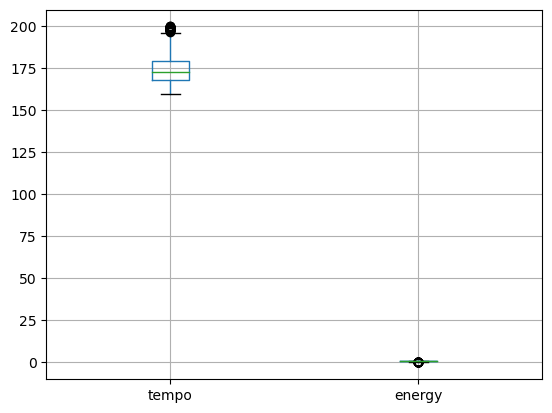

In [69]:
sottodf.boxplot()
plt.show()

In [70]:
df2[(df2["tempo"]<173.066)&(df2["tempo"]>160)]

,name,duration_ms,explicit,popularity,artists,album_name,danceability,energy,key,loudness,...,liveness,valence,tempo,features_duration_ms,time_signature,n_beats,n_bars,popularity_confidence,processing,genre
28,愛上你算我賤,250941,False,55,NICKTHEREAL,REAL LIFE,0.478,0.738,6,-4.464,...,0.1540,0.3530,163.994,250942,4.0,670.0,167.0,NaN,1.170953,mandopop
49,Cloudy Daze - Ham Mix,323928,False,23,Bang!,Cloudy Daze,0.593,0.588,10,-14.420,...,0.0639,0.3280,169.857,323928,4.0,900.0,225.0,0.525,0.757389,happy
77,Dooms Day,227056,False,8,Arsames,Immortal Identity,0.456,0.992,7,-3.817,...,0.3330,0.4160,165.012,227056,4.0,611.0,153.0,0.106,4.067086,iranian
79,Sick Of It All,301383,False,24,Nosferatu;Evil Activities,Strength,0.596,0.997,6,-3.259,...,0.5840,0.1500,169.968,301383,4.0,847.0,212.0,NaN,1.170953,happy
88,イエローライト,274466,False,17,Shiritsu Ebisu Chugaku,私立恵比寿中学,0.459,0.856,8,-4.676,...,0.0261,0.6450,168.171,274467,4.0,749.0,188.0,NaN,2.725904,j-idol
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14919,Plus,83034,False,1,DJ Sim,Plus,0.660,0.754,8,-7.807,...,0.1730,0.6630,168.192,83035,4.0,232.0,57.0,NaN,2.725904,happy
14928,R.U.A 12 Batalha de Vida,618000,True,39,Fabio Brazza;Nocivo Shomon;Jhony Mc;Krawk;Max ...,R.U.A 12 Batalha de Vida,0.739,0.571,4,-10.343,...,0.3240,0.6560,160.191,618000,4.0,1645.0,413.0,NaN,0.916010,brazil
14949,Agora Eu Pego Mesmo,155637,False,48,Os Barões Da Pisadinha,Agora Eu Pego Mesmo,0.815,0.887,9,-6.386,...,0.0978,0.9520,172.032,155638,4.0,445.0,111.0,NaN,1.343558,forro
14952,No Newstyle - Buzz Fuzz Remix,415171,False,16,The Masochist;Buzz Fuzz,Thunderdome 25 Years Of Hardcore,0.455,0.727,6,-11.574,...,0.1160,0.0442,164.871,415172,4.0,1113.0,280.0,NaN,1.170953,happy
